# Logistic Regression with Python

## Import libraries


In [84]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

## The Data
Let's start by reading in the titanic_train.csv file into a pandas dataframe.

In [85]:
train = pd.read_csv('titanic_train.csv')

In [86]:
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


##  EDA

### Missing data
We can use seaborn to create a simple heatmap to see where we are missing data!

In [87]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [88]:
train.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


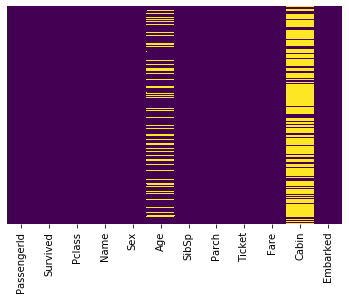

In [89]:
sns.heatmap(train.isnull(), yticklabels=False, cbar=False, cmap='viridis')

Roughly 20 percent of the Age data is missing. The proportion of Age missing is likely small enough for reasonable replacement with some form of imputation. Looking at the Cabin column, it looks like we are just missing too much of that data to do something useful with at a basic level. We'll probably drop this later, or change it to another feature like "Cabin Known: 1 or 0"

Let's continue on by visualizing some more of the data! Check out the video for full explanations over these plots, this code is just to serve as reference.

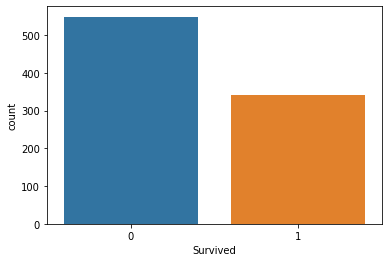

In [90]:
sns.countplot(x='Survived', data=train)

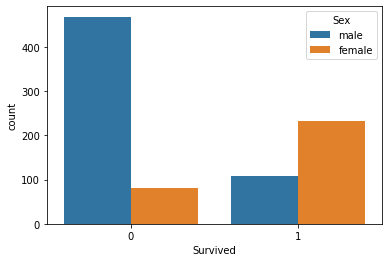

In [91]:
sns.countplot(x='Survived', hue='Sex', data=train)

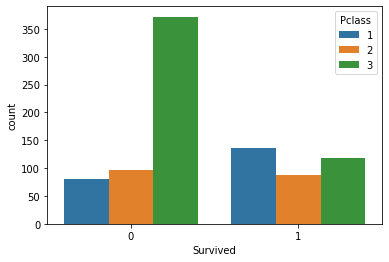

In [92]:
sns.countplot(x='Survived', hue='Pclass', data=train)

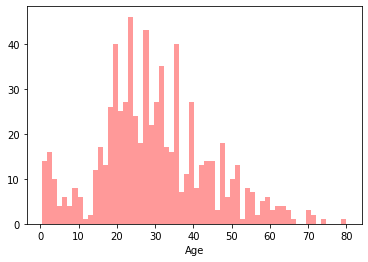

In [93]:
sns.distplot(train['Age'].dropna(), kde=False, color='red', bins=60)

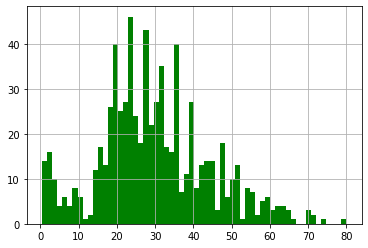

In [94]:
train['Age'].hist(bins=60, color='green')

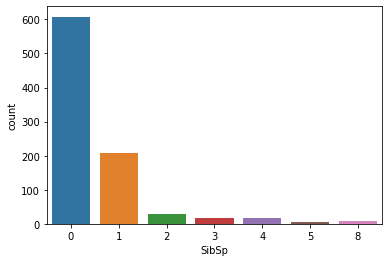

In [95]:
sns.countplot(x='SibSp', data=train)

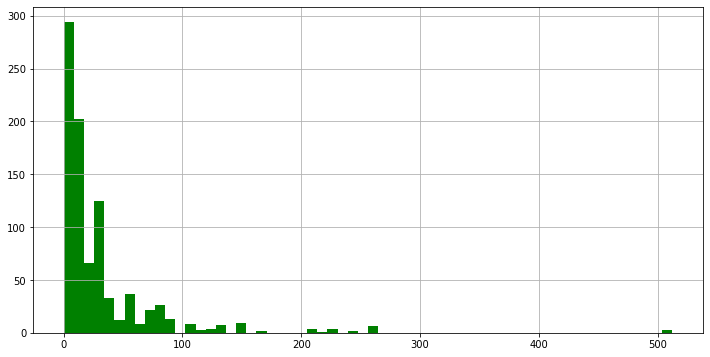

In [96]:
train['Fare'].hist(color='green', bins=60, figsize=(12,6))

## Data cleaning

We want to fill in missing age data instead of just dropping the missing age data rows. One way to do this is by filling in the mean age of all the passengers (imputation). However we can be smarter about this and check the average age by passenger class. For example:

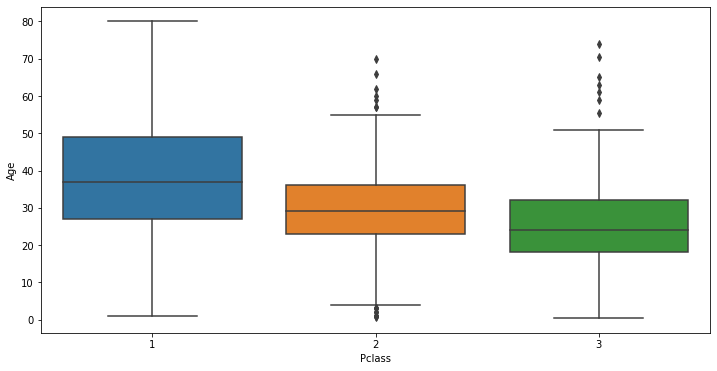

In [97]:
plt.figure(figsize=(12,6))
sns.boxplot(x='Pclass', y='Age', data=train)

We can see the wealthier passengers in the higher classes tend to be older, which makes sense. We'll use these average age values to impute based on Pclass for Age.

In [98]:
def impute_age(cols):
    Age = cols[0]
    Pclass = cols[1]
    
    if pd.isnull(Age):
        if Pclass == 1:
            return 37
        elif Pclass == 2:
            return 29
        elif Pclass == 3:
            return 24
    else:
        return Age
    

In [99]:
train['Age'] = train[['Age','Pclass']].apply(impute_age, axis=1)

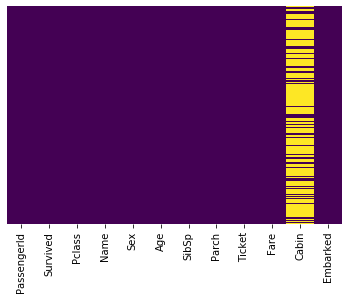

In [100]:
sns.heatmap(train.isnull(), yticklabels=False, cbar=False, cmap='viridis')

Great! Let's go ahead and drop the Cabin column.

In [101]:
train.drop('Cabin', axis=1, inplace=True)

In [102]:
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,S


## Converting categorical features

We'll need to convert categorical features to dummy variables using pandas! Otherwise our machine learning algorithm won't be able to directly take in those features as inputs.

In [103]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 11 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            891 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(4)
memory usage: 76.7+ KB


In [104]:
sex = pd.get_dummies(train['Sex'], drop_first=True)

In [105]:
embark = pd.get_dummies(train['Embarked'], drop_first=True)

In [106]:
train.drop(['Sex', 'Embarked', 'Name', 'Ticket'], axis=1, inplace=True)

In [107]:
train.head()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
0,1,0,3,22.0,1,0,7.2500
1,2,1,1,38.0,1,0,71.2833
2,3,1,3,26.0,0,0,7.9250
3,4,1,1,35.0,1,0,53.1000
4,5,0,3,35.0,0,0,8.0500


In [108]:
train = pd.concat([train,sex,embark], axis=1)

In [109]:
train.head()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare,male,Q,S
0,1,0,3,22.0,1,0,7.2500,1,0,1
1,2,1,1,38.0,1,0,71.2833,0,0,0
2,3,1,3,26.0,0,0,7.9250,0,0,1
3,4,1,1,35.0,1,0,53.1000,0,0,1
4,5,0,3,35.0,0,0,8.0500,1,0,1


Our data is ready for our model!

## Building a Logistic Regression model
Let's start by splitting our data into a training set and test set

### Splitting the data into dependent and Independent variable

In [110]:
X = train.drop('Survived', axis=1)

In [112]:
y = train['Survived']

## Train Test Split

In [116]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=101)

## Training and Predecting

In [118]:
from sklearn.linear_model import LogisticRegression
log_reg = LogisticRegression()
log_reg.fit(X_train,y_train)

C:\Users\Nishant\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

In [123]:
predections = log_reg.predict(X_test)

## Evaluation
We can check precision using classification report and confusion matrix


In [126]:
from sklearn.metrics import classification_report, confusion_matrix

In [127]:
print(classification_report(y_test,predections))

              precision    recall  f1-score   support

           0       0.77      0.88      0.82       154
           1       0.79      0.64      0.71       114

    accuracy                           0.78       268
   macro avg       0.78      0.76      0.76       268
weighted avg       0.78      0.78      0.77       268



In [128]:
print(confusion_matrix(y_test,predections))

[[135  19]
 [ 41  73]]
